# Age, Gender, and Expression Recognition

## Notebook Imports

In [1]:
import os
import pathlib
import sklearn
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
from tqdm.autonotebook import tqdm
from timeit import default_timer as timer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms
torch.__version__

/tmp/ipykernel_23/1791553448.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'2.4.0'

## Data Loading & Data Preprocessing

In [2]:
EMOTION_IMAGE_PATH = Path("/kaggle/input/emotion-detection-fer")

EMOTION_TRAIN_PATH = EMOTION_IMAGE_PATH / "train"
EMOTION_TEST_PATH = EMOTION_IMAGE_PATH / "test"

TRAIN_EMOTION_IMAGE_PATH_LIST = list(EMOTION_TRAIN_PATH.glob('*/*.png'))
TEST_EMOTION_IMAGE_PATH_LIST = list(EMOTION_TEST_PATH.glob('*/*.png'))

AGEUTK = Path("/kaggle/input/ageutk")
AGEUTK_PATH_LIST = list((AGEUTK / 'UTKFace').glob("*/*/*.jpg.chip.jpg"))

In [3]:
def parse_filename(filename):
    parts = filename.split("_")
    return {"path": f"/kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/{filename}", "age": int(parts[0]), "gender": int(parts[1])}

In [4]:
ageutkface_data = [parse_filename(path.name) for path in AGEUTK_PATH_LIST]
ageutkface_metadata = pd.DataFrame(ageutkface_data)

In [5]:
print(f"Min age: {ageutkface_metadata['age'].min()}, Max age: {ageutkface_metadata['age'].max()}")
print(ageutkface_metadata['age'].dtype)
ageutkface_metadata.loc[ageutkface_metadata['age'] > 70, 'age'] = 70

Min age: 1, Max age: 116
int64


In [6]:
age_bins = [0, 12, 19, 28, 55, 70]
age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']

ageutkface_metadata['age'] = pd.cut(
    ageutkface_metadata['age'], bins=age_bins, 
    labels=age_labels, right=True
)

In [7]:
train_ageutk, test_ageutk = train_test_split(ageutkface_metadata, shuffle=True, test_size=0.1)
train_ageutk, val_ageutk = train_test_split(train_ageutk, shuffle=True, test_size=0.2)
train_ageutk.head()

path          age  gender
5043   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       0
15683  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       1
19088  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/3...        Adult       0
7114   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       0
9446   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/6...      Elderly       0

In [8]:
train_emotion_data = [{'path': path, 'emotion': path.parent.stem} for path in TRAIN_EMOTION_IMAGE_PATH_LIST if path.parent.stem != 'disgusted' and path.parent.stem != 'fearful']
test_emotion_data = [{'path': path, 'emotion': path.parent.stem} for path in TEST_EMOTION_IMAGE_PATH_LIST if path.parent.stem != 'disgusted' and path.parent.stem != 'fearful']

train_emotion= pd.DataFrame(train_emotion_data)
test_emotion= pd.DataFrame(test_emotion_data)
train_emotion, val_emotion = train_test_split(train_emotion, shuffle=True, test_size=0.2)

train_emotion.head()

path emotion
12545  /kaggle/input/emotion-detection-fer/train/sad/...     sad
23047  /kaggle/input/emotion-detection-fer/train/happ...   happy
9467   /kaggle/input/emotion-detection-fer/train/sad/...     sad
20935  /kaggle/input/emotion-detection-fer/train/happ...   happy
24039  /kaggle/input/emotion-detection-fer/train/happ...   happy

In [9]:
print('Train Value Counts: ', train_ageutk['age'].value_counts(), train_ageutk['gender'].value_counts(), train_emotion['emotion'].value_counts())
print('Test Value Counts: ', test_ageutk['age'].value_counts(), test_ageutk['gender'].value_counts(), test_emotion['emotion'].value_counts())
print('Shape of Datasets: ', train_ageutk.shape, test_ageutk.shape, train_emotion.shape, test_emotion.shape)

Train Value Counts:  age
Adult          6445
Young Adult    4886
Child          2457
Elderly        2445
Teen            835
Name: count, dtype: int64 gender
0    8902
1    8166
Name: count, dtype: int64 emotion
happy        5805
neutral      3939
sad          3853
angry        3190
surprised    2553
Name: count, dtype: int64
Test Value Counts:  age
Adult          902
Young Adult    660
Child          353
Elderly        334
Teen           122
Name: count, dtype: int64 gender
0    1218
1    1153
Name: count, dtype: int64 emotion
happy        1774
sad          1247
neutral      1233
angry         958
surprised     831
Name: count, dtype: int64
Shape of Datasets:  (17068, 3) (2371, 3) (19340, 2) (6043, 2)


## Data Transformation

In [10]:
train_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None, emotion=True):
    """Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version."""
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            if emotion:
                f = f.convert('RGB')
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # Original Image
            ax[0].imshow(f)
            ax[0].set_title(f'Original Image \nSize: {f.size}')
            ax[0].axis(False)

            # Transformed Image
            transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C) for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Image \nSize: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=14)

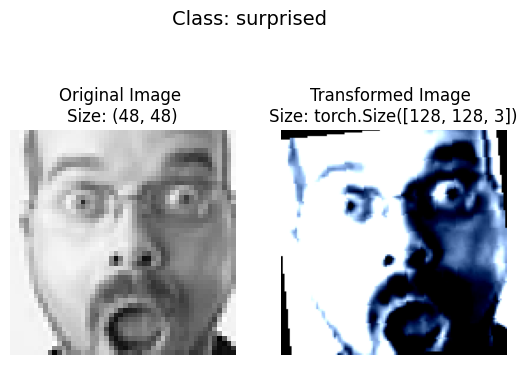

In [12]:
plot_transformed_images(image_paths=TRAIN_EMOTION_IMAGE_PATH_LIST,
                        transform=train_transform,
                        n=1,
                        seed=42)

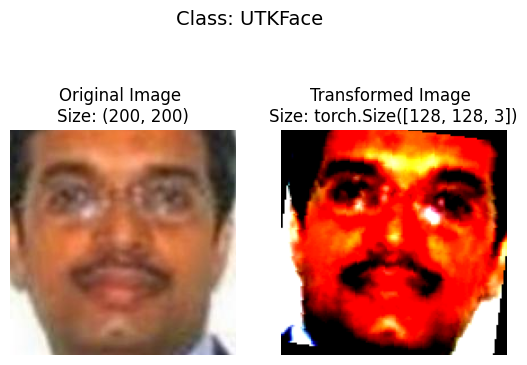

In [13]:
plot_transformed_images(image_paths=AGEUTK_PATH_LIST,
                        transform=train_transform,
                        n=1, emotion=False,
                        seed=42)

## Combining Emotion and UTKFace Datasets

Creating a custom PyTorch Dataset class to integrate the datasets for emotion, age, and gender

In [14]:
emotion_idx = {
    'angry': 0,
    'happy': 1,
    'neutral': 2,
    'sad': 3,
    'surprised': 4
}

age_idx = {label:i for i, label in enumerate(age_labels)}

emotion_names = list(emotion_idx.keys())
age_names = list(age_idx.keys())
emotion_names, age_names

(['angry', 'happy', 'neutral', 'sad', 'surprised'],
 ['Child', 'Teen', 'Young Adult', 'Adult', 'Elderly'])

In [15]:
class CombinedCustomDataset(Dataset):
    def __init__(self, emotion_metadata, ageutkface_metadata, emotion_idx:dict, age_idx:dict, transform=None):
        self.ageutk_df = ageutkface_metadata
        self.emotion_df = emotion_metadata
        self.transform = transform
        self.emotion_idx = emotion_idx
        self.age_idx = age_idx

    def __len__(self):
        return len(self.ageutk_df) + len(self.emotion_df)

    def __getitem__(self, idx):
        if idx < len(self.ageutk_df):  # AGE-UTK sample
            row = self.ageutk_df.iloc[idx]
            image = Image.open(row['path'])
            label = [
                self.age_idx[row['age']],
                row['gender'],
                -1
            ]
        else:  # Emotion sample
            row = self.emotion_df.iloc[idx - len(self.ageutk_df)]
            image = Image.open(row['path']).convert('RGB')
            label = [
                -1, 
                -1,
                self.emotion_idx[row['emotion']]
            ]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label)

In [16]:
train_combined_dataset = CombinedCustomDataset(emotion_metadata=train_emotion, ageutkface_metadata=train_ageutk, 
                                               transform=train_transform, emotion_idx=emotion_idx, age_idx=age_idx)

val_combined_dataset = CombinedCustomDataset(emotion_metadata=val_emotion, ageutkface_metadata=val_ageutk, 
                                              transform=test_transform, emotion_idx=emotion_idx, age_idx=age_idx)

test_combined_dataset = CombinedCustomDataset(emotion_metadata=test_emotion, ageutkface_metadata=test_ageutk,
                                              emotion_idx=emotion_idx, age_idx=age_idx, transform=test_transform)


train_combined_dataloader = DataLoader(train_combined_dataset, batch_size=16, 
                                       shuffle=True, num_workers=os.cpu_count())

val_combined_dataloader = DataLoader(val_combined_dataset, batch_size=16,
                                     shuffle=True, num_workers=os.cpu_count())

test_combined_dataloader = DataLoader(test_combined_dataset, batch_size=16, 
                                      shuffle=True, num_workers=os.cpu_count())

In [17]:
train_images, train_labels = next(iter(train_combined_dataloader))
train_images.shape, train_labels.shape, train_labels[:5]

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3]),
 tensor([[ 3,  0, -1],
         [ 2,  1, -1],
         [ 2,  0, -1],
         [ 3,  1, -1],
         [-1, -1,  3]]))

In [18]:
val_images, val_labels = next(iter(val_combined_dataloader))
val_images.shape, val_labels.shape, val_labels[:5]

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3]),
 tensor([[ 2,  1, -1],
         [-1, -1,  3],
         [ 2,  0, -1],
         [-1, -1,  4],
         [ 3,  1, -1]]))

In [19]:
# Visualize images with their labels
def visualize_batch(images, labels):
    """
    Visualizes a batch of images in an 4x4 grid.
    
    Parameters:
        images (torch.Tensor): Batch of images (B, C, H, W).
        labels (list): Corresponding labels [[age_idx, gender_idx, emotion_idx], ...].
    """
    # Define the grid size
    rows, cols = 4, 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 20))
    
    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            ax.axis('off')
            continue
        
        image = images[i]
        
        # Display the image
        ax.imshow(image.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
        ax.set_title(f"Age Id: {labels[i][0]}\nGender Id: {labels[i][1]}\nEmotion Id: {labels[i][2]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

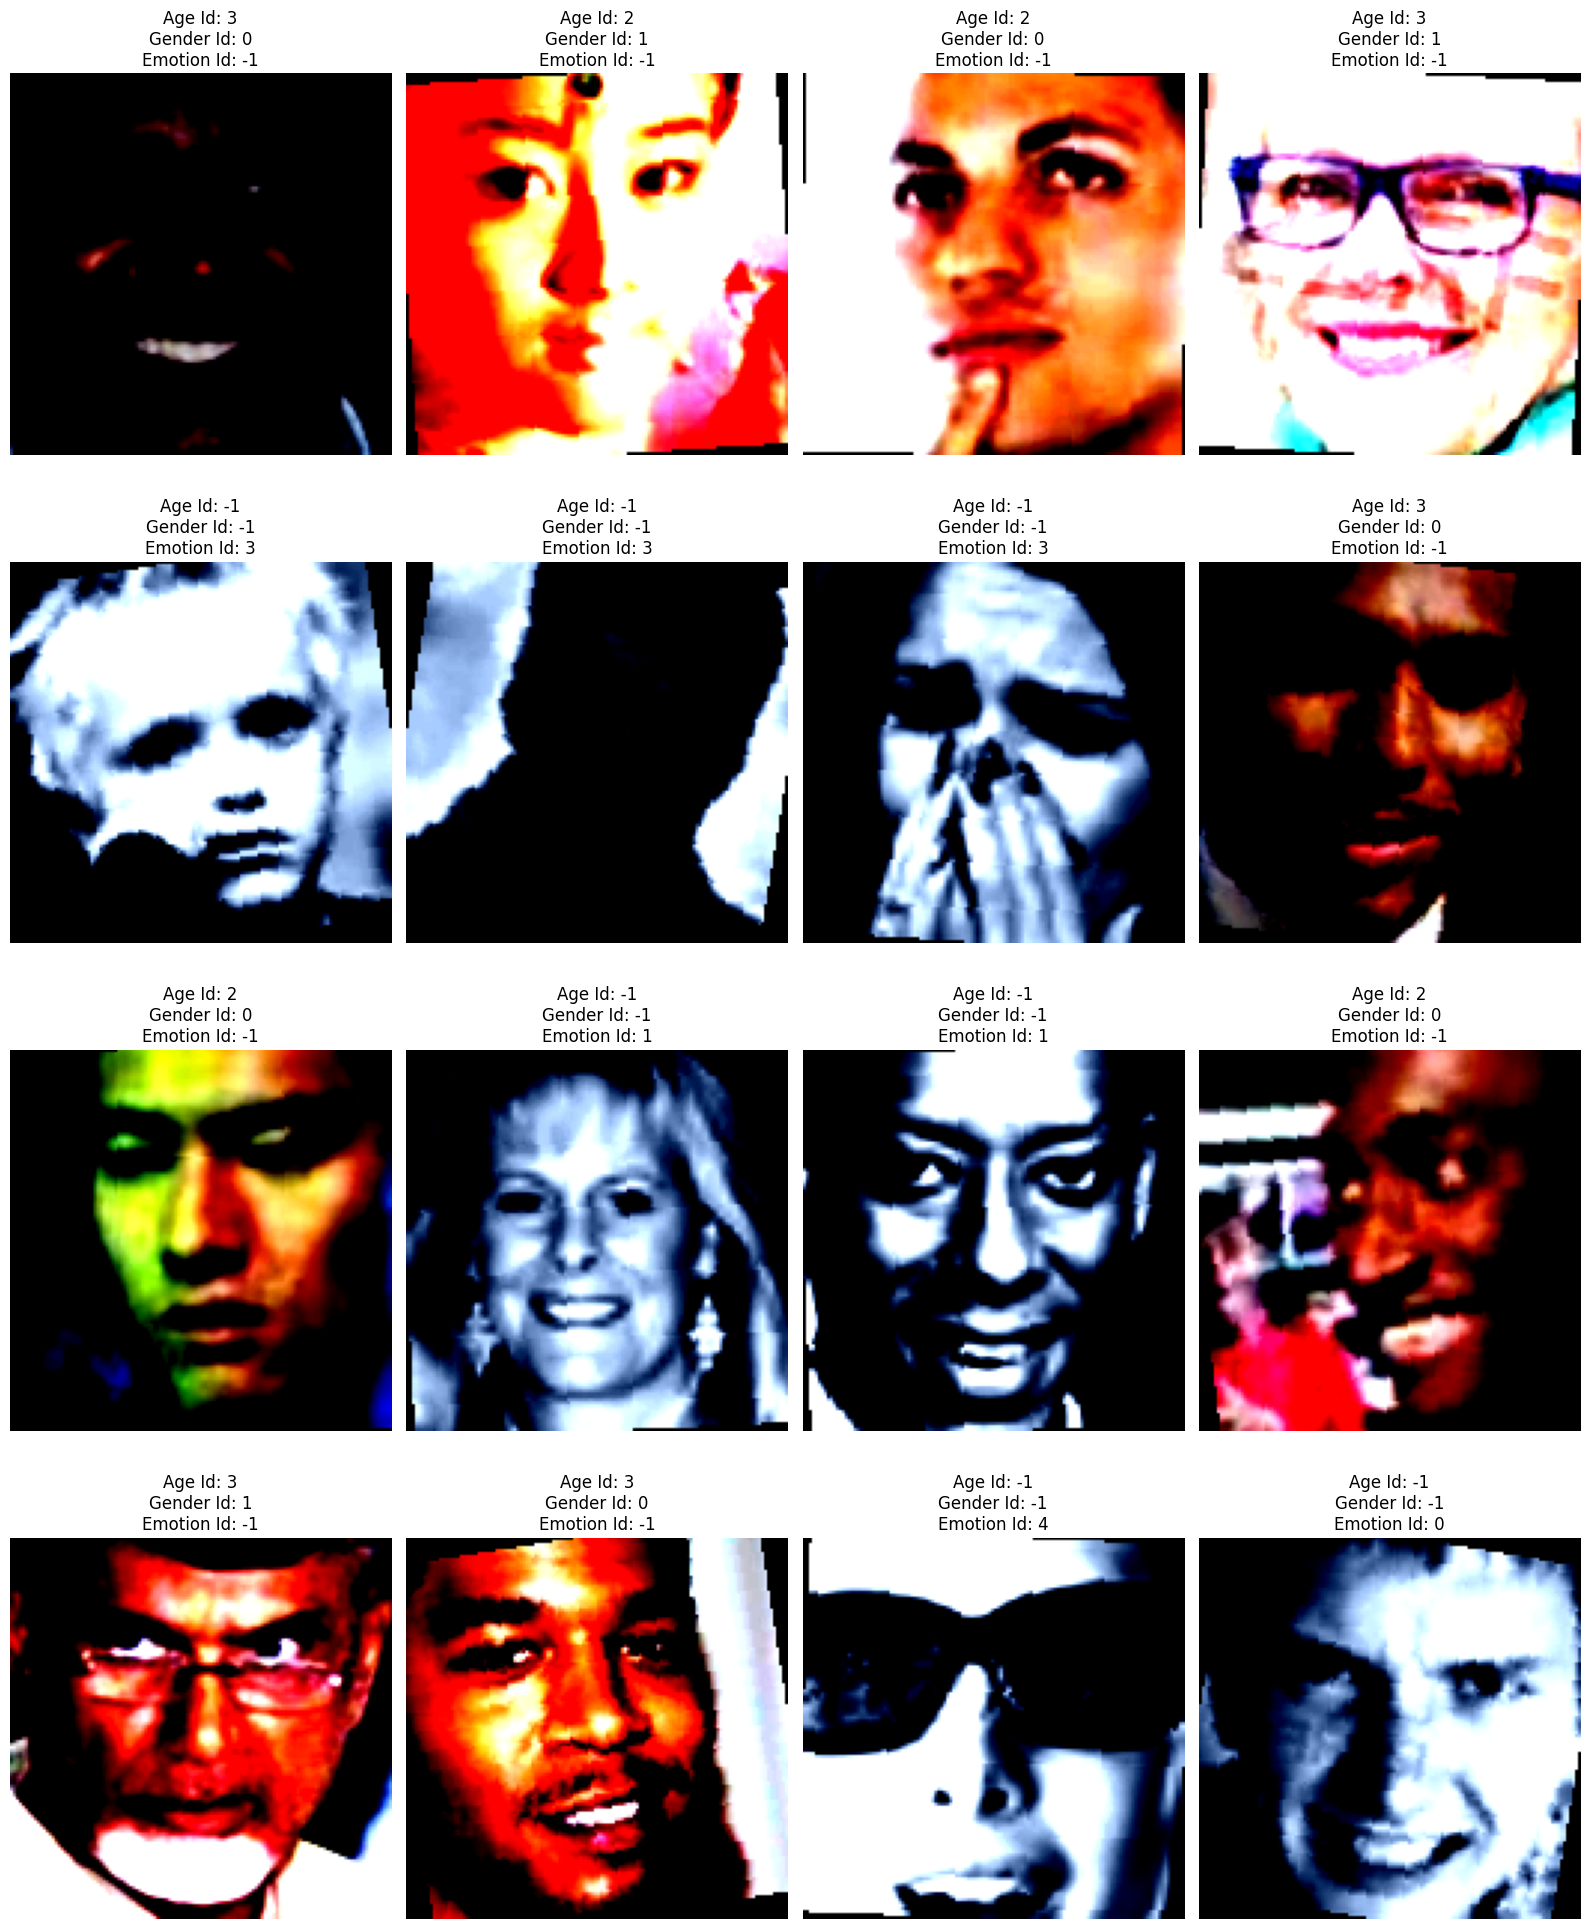

In [20]:
visualize_batch(train_images, train_labels)

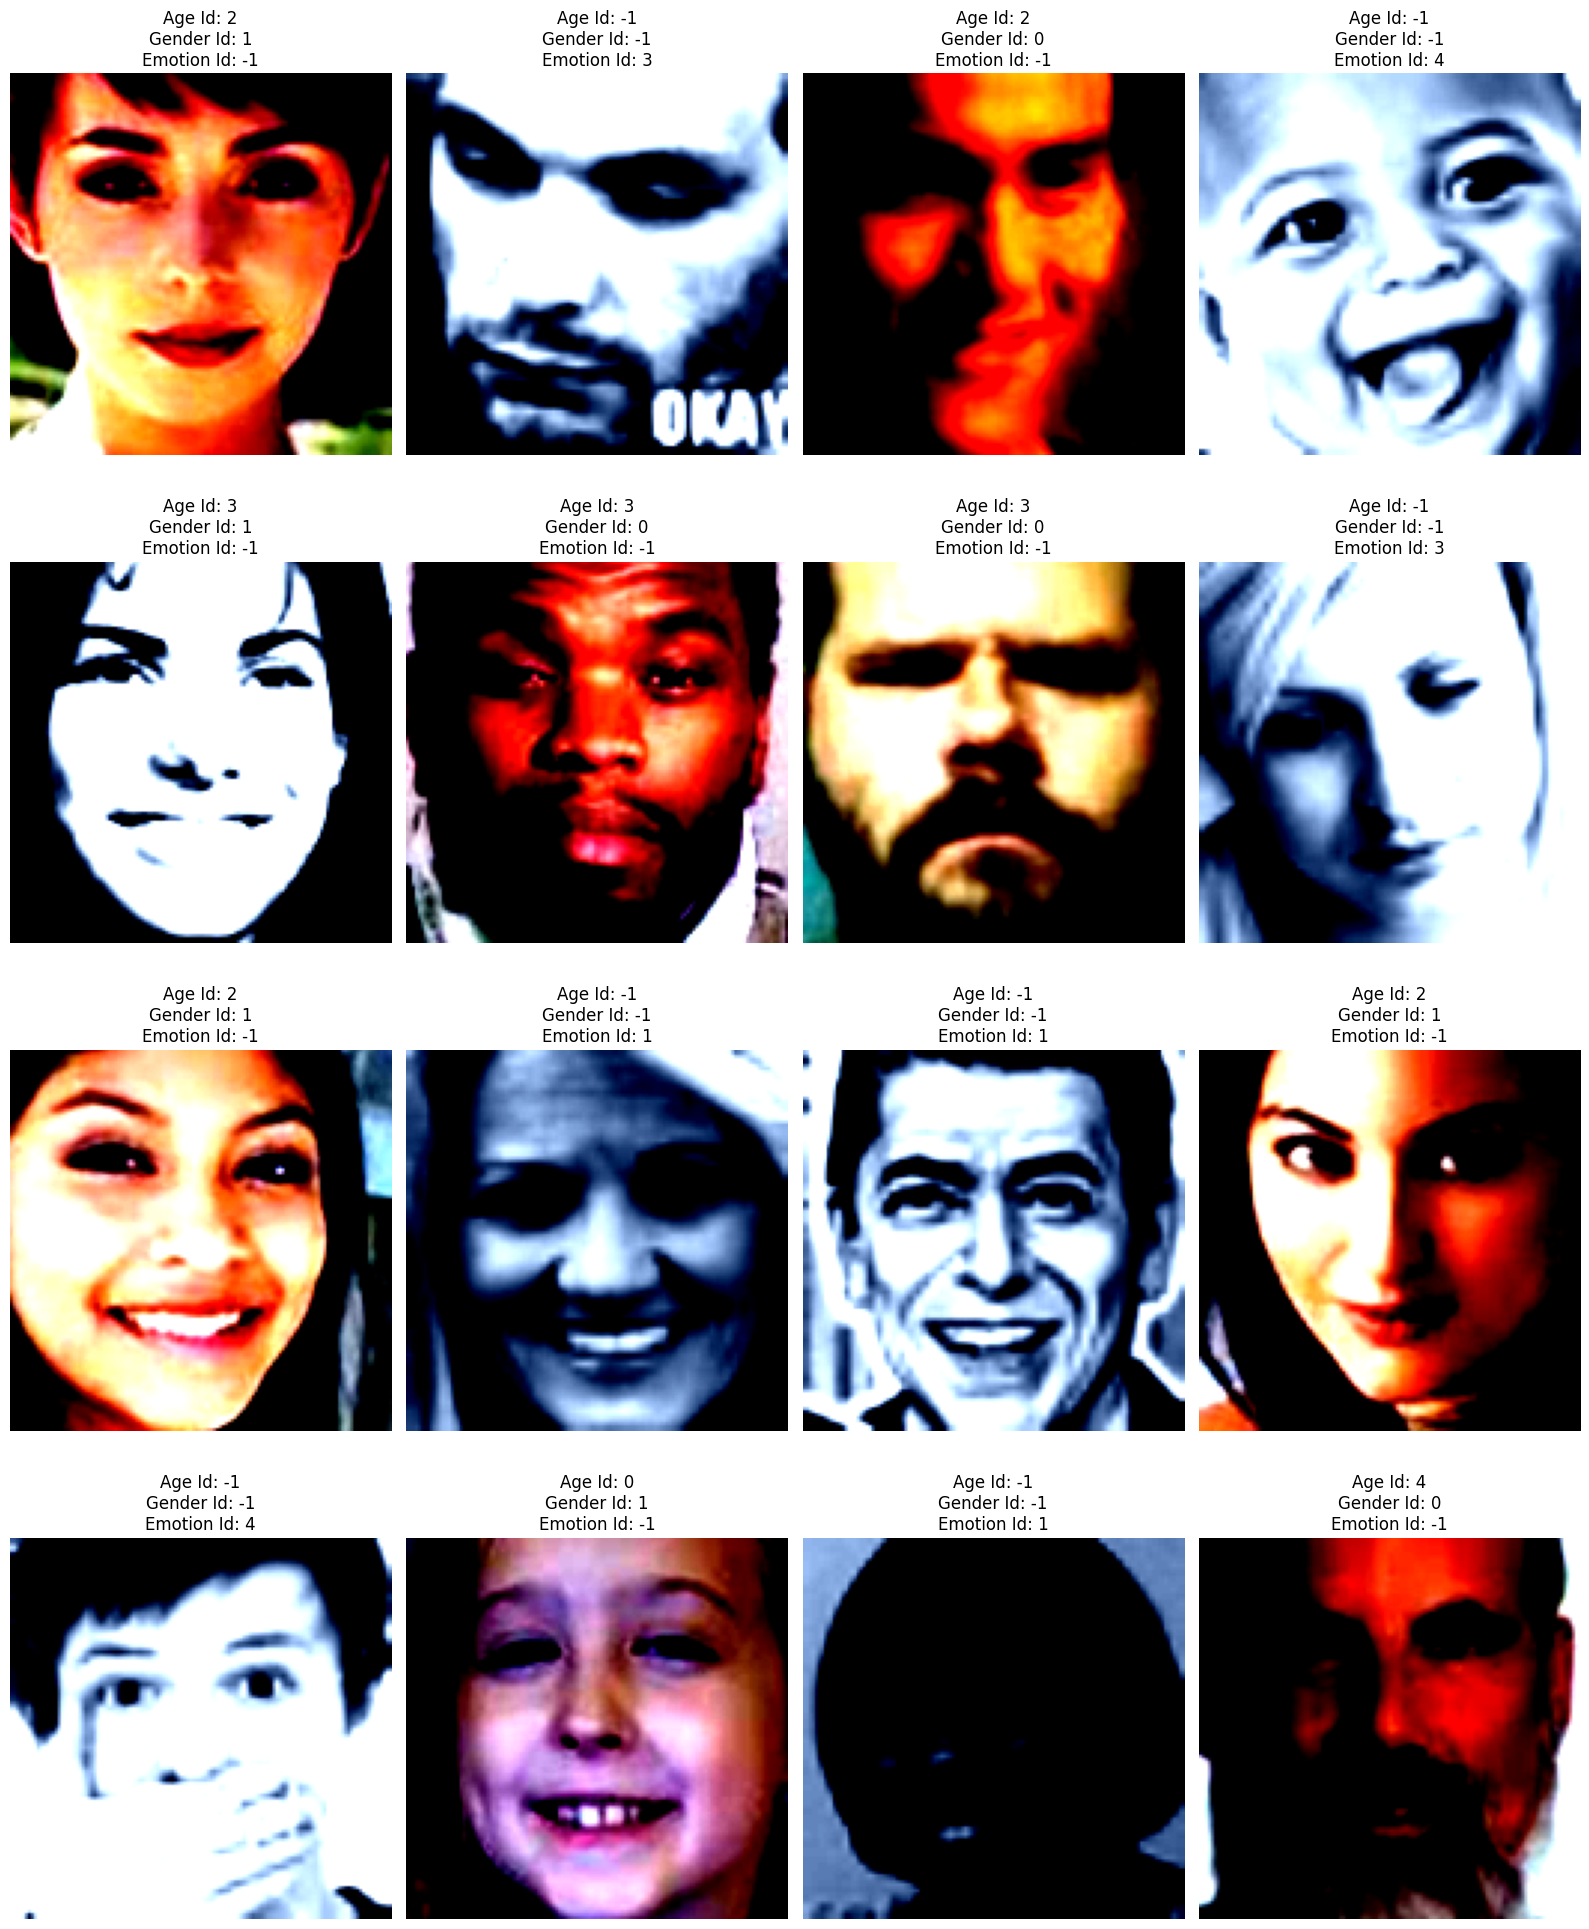

In [21]:
visualize_batch(val_images, val_labels)

## Model Training & Evaluation

### Model Architecture

In [22]:
class CustomMultiHeadModel(nn.Module):
    def __init__(self, num_age_bins: int, num_genders: int,
                 hidden_units: int, num_emotions: int) -> None:
        super().__init__()

        backbone = models.resnet18(pretrained=True)
        self.shared_backbone = nn.Sequential(
            *list(backbone.children())[:-2],  # Remove the fully connected layers
            nn.AdaptiveAvgPool2d((1, 1))  # Pool to (1, 1) spatial dimensions
        )

        # Heads for age, gender, and emotion
        self.age_head = nn.Sequential(
            nn.Linear(512, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, num_age_bins)
        )
        self.gender_head = nn.Sequential(
            nn.Linear(512, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, num_genders)
        )
        self.emotion_head = nn.Sequential(
            nn.Linear(512, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, num_emotions)
        )

    def forward(self, x):
        features = self.shared_backbone(x)  # Extract features
        features = torch.flatten(features, 1)  # Flatten to 1D
        age_logits = self.age_head(features)  # Predict age
        gender_logits = self.gender_head(features)  # Predict gender
        emotion_logits = self.emotion_head(features)  # Predict emotion
        return age_logits, gender_logits, emotion_logits

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Model Training
* `train_step()` -- takes a model and dataloader and trains the model on the `DataLoader`
* `test_step()` -- takes a model and dataloader and evaluates the model on the `DataLoader`

In [24]:
def train_step(model, dataloader, age_loss_fn, gender_loss_fn, emotion_loss_fn, optimizer, device=device):
    """
    Perform a single training step for one epoch.

    Parameters:
        model: PyTorch multi-head model.
        dataloader: DataLoader for training data.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for age, gender, and emotion tasks.
        optimizer: Optimizer to update the model parameters.
        device: Device for computation (e.g., "cpu" or "cuda").

    Returns:
        train_loss: Average loss over the epoch.
        train_acc: Average accuracy across all tasks.
        overall_accuracy: Dictionary of task-specific accuracies.
    """
    model.train()
    train_loss = 0
    total_age_accuracy, total_gender_accuracy, total_emotion_accuracy = 0, 0, 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward Pass
        age_pred, gender_pred, emotion_pred = model(X)

        # Initialize accumulators
        num_tasks = 0
        batch_loss = 0

        # Calculate and mask Age Loss
        valid_age_indices = y[:, 0] != -1
        if valid_age_indices.sum() > 0:
            age_loss = age_loss_fn(age_pred[valid_age_indices], y[valid_age_indices, 0].long())
            batch_loss += age_loss
            num_tasks += 1

            # Age Accuracy
            age_pred_class = age_pred.argmax(dim=1)
            age_accuracy = (age_pred_class[valid_age_indices] == y[valid_age_indices, 0]).sum().item() / valid_age_indices.sum().item()
            total_age_accuracy += age_accuracy

        # Calculate and mask Gender Loss
        valid_gender_indices = y[:, 1] != -1
        if valid_gender_indices.sum() > 0:
            gender_loss = gender_loss_fn(gender_pred[valid_gender_indices], y[valid_gender_indices, 1].long())
            batch_loss += gender_loss
            num_tasks += 1

            # Gender Accuracy
            gender_pred_class = gender_pred.argmax(dim=1)
            gender_accuracy = (gender_pred_class[valid_gender_indices] == y[valid_gender_indices, 1]).sum().item() / valid_gender_indices.sum().item()
            total_gender_accuracy += gender_accuracy

        # Calculate and mask Emotion Loss
        valid_emotion_indices = y[:, 2] != -1
        if valid_emotion_indices.sum() > 0:
            emotion_loss = emotion_loss_fn(emotion_pred[valid_emotion_indices], y[valid_emotion_indices, 2].long())
            batch_loss += emotion_loss
            num_tasks += 1

            # Emotion Accuracy
            emotion_pred_class = emotion_pred.argmax(dim=1)
            emotion_accuracy = (emotion_pred_class[valid_emotion_indices] == y[valid_emotion_indices, 2]).sum().item() / valid_emotion_indices.sum().item()
            total_emotion_accuracy += emotion_accuracy

        # Backpropagation
        optimizer.zero_grad()
        if num_tasks > 0:  # Avoid division by zero
            batch_loss = batch_loss / num_tasks
            train_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()

    # Average Loss and Accuracy
    train_loss /= num_batches
    avg_age_accuracy = total_age_accuracy / num_batches
    avg_gender_accuracy = total_gender_accuracy / num_batches
    avg_emotion_accuracy = total_emotion_accuracy / num_batches
    train_acc = (avg_age_accuracy + avg_gender_accuracy + avg_emotion_accuracy) / 3

    overall_accuracy = {
        "Age Acc": round(avg_age_accuracy, 3), 
        "Gender Acc": round(avg_gender_accuracy,3),
        "Emotion Acc": round(avg_emotion_accuracy, 3)
    }

    return train_loss, train_acc, overall_accuracy

In [25]:
def test_step(model, dataloader, age_loss_fn, gender_loss_fn, emotion_loss_fn, device=device):
    """
    Perform a single testing step.

    Parameters:
        model: PyTorch multi-head model.
        dataloader: DataLoader for test data.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for age, gender, and emotion tasks.
        device: Device for computation (e.g., "cpu" or "cuda").

    Returns:
        test_loss: Average loss over the epoch.
        test_acc: Average accuracy across all tasks.
        overall_accuracy: Dictionary of task-specific accuracies.
    """
    model.eval()
    test_loss = 0
    total_age_accuracy, total_gender_accuracy, total_emotion_accuracy = 0, 0, 0
    num_batches = len(dataloader)

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward Pass
            age_pred, gender_pred, emotion_pred = model(X)

            # Initialize accumulators
            num_tasks = 0
            batch_loss = 0

            # Calculate and mask Age Loss
            valid_age_indices = y[:, 0] != -1
            if valid_age_indices.sum() > 0:
                age_loss = age_loss_fn(age_pred[valid_age_indices], y[valid_age_indices, 0].long())
                batch_loss += age_loss
                num_tasks += 1

                # Age Accuracy
                age_pred_class = age_pred.argmax(dim=1)
                age_accuracy = (age_pred_class[valid_age_indices] == y[valid_age_indices, 0]).sum().item() / valid_age_indices.sum().item()
                total_age_accuracy += age_accuracy

            # Calculate and mask Gender Loss
            valid_gender_indices = y[:, 1] != -1
            if valid_gender_indices.sum() > 0:
                gender_loss = gender_loss_fn(gender_pred[valid_gender_indices], y[valid_gender_indices, 1].long())
                batch_loss += gender_loss
                num_tasks += 1

                # Gender Accuracy
                gender_pred_class = gender_pred.argmax(dim=1)
                gender_accuracy = (gender_pred_class[valid_gender_indices] == y[valid_gender_indices, 1]).sum().item() / valid_gender_indices.sum().item()
                total_gender_accuracy += gender_accuracy

            # Calculate and mask Emotion Loss
            valid_emotion_indices = y[:, 2] != -1
            if valid_emotion_indices.sum() > 0:
                emotion_loss = emotion_loss_fn(emotion_pred[valid_emotion_indices], y[valid_emotion_indices, 2].long())
                batch_loss += emotion_loss
                num_tasks += 1

                # Emotion Accuracy
                emotion_pred_class = emotion_pred.argmax(dim=1)
                emotion_accuracy = (emotion_pred_class[valid_emotion_indices] == y[valid_emotion_indices, 2]).sum().item() / valid_emotion_indices.sum().item()
                total_emotion_accuracy += emotion_accuracy

            # Accumulate Total Loss
            if num_tasks > 0:  # Avoid division by zero
                batch_loss = batch_loss / num_tasks
                test_loss += batch_loss.item()

    # Average Loss and Accuracy
    test_loss /= num_batches
    avg_age_accuracy = total_age_accuracy / num_batches
    avg_gender_accuracy = total_gender_accuracy / num_batches
    avg_emotion_accuracy = total_emotion_accuracy / num_batches
    test_acc = (avg_age_accuracy + avg_gender_accuracy + avg_emotion_accuracy) / 3

    overall_accuracy = {
        "Age Acc": round(avg_age_accuracy, 3),
        "Gender Acc": round(avg_gender_accuracy,3), 
        "Emotion Acc": round(avg_emotion_accuracy, 3)
    }

    return test_loss, test_acc, overall_accuracy

In [26]:
def train(model, 
          train_dataloader, 
          test_dataloader, 
          optimizer, 
          age_loss_fn, 
          gender_loss_fn, 
          emotion_loss_fn, 
          epochs, 
          device=device):
    """
    Training loop for multi-head model.

    Parameters:
        model: PyTorch multi-head model.
        train_dataloader: DataLoader for training data.
        test_dataloader: DataLoader for testing data.
        optimizer: Optimizer for the model.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for each task.
        epochs: Number of epochs to train the model.
        device: Device for computation (e.g., "cuda" or "cpu").

    Returns:
        results: Dictionary containing training and testing losses and accuracies.
    """
    results = {
        'train_loss': [],
        'train_acc': [],
        'train_overall_acc': [],
        'test_loss': [],
        'test_acc': [],
        'test_overall_acc': []
    }

    for epoch in range(epochs):

        # Training Step
        train_loss, train_acc, train_overall_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            age_loss_fn=age_loss_fn,
            gender_loss_fn=gender_loss_fn,
            emotion_loss_fn=emotion_loss_fn,
            optimizer=optimizer,
            device=device
        )

        # Testing Step
        test_loss, test_acc, test_overall_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            age_loss_fn=age_loss_fn,
            gender_loss_fn=gender_loss_fn,
            emotion_loss_fn=emotion_loss_fn,
            device=device
        )
        # Logging
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
        print(f"Train Overall Accuracy: {train_overall_acc}")
        print(f"Test Overall Accuracy: {test_overall_acc}")

        # Append Results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['train_overall_acc'].append(train_overall_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        results['test_overall_acc'].append(test_overall_acc)

    return results

In [27]:
EPOCHS = 5
NUM_AGE_BINS = len(age_labels)
NUM_GENDERS = 2
NUM_EMOTIONS = 7

In [28]:
multi_head_model = CustomMultiHeadModel(num_age_bins=NUM_AGE_BINS, num_genders=NUM_GENDERS,
                                        num_emotions=NUM_EMOTIONS, hidden_units=512).to(device)

optimizer = torch.optim.Adam(multi_head_model.parameters(), lr=0.001)

age_loss_fn = nn.CrossEntropyLoss()
gender_loss_fn = nn.CrossEntropyLoss()
emotion_loss_fn = nn.CrossEntropyLoss()

summary(multi_head_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


Layer (type:depth-idx)                        Param #
CustomMultiHeadModel                          --
├─Sequential: 1-1                             --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
│    └─AdaptiveA

In [29]:
start_time = timer()

model_results = train(model=multi_head_model, train_dataloader=train_combined_dataloader,
                      test_dataloader=val_combined_dataloader, optimizer=optimizer, 
                      age_loss_fn=age_loss_fn, gender_loss_fn=gender_loss_fn, 
                      emotion_loss_fn=emotion_loss_fn, epochs=EPOCHS)

end_time = timer()
print(f'Total Training Time: {end_time - start_time:.3f} seconds')


Epoch 1/5
Train Loss: 0.8926 | Train Acc: 0.6188
Test Loss: 0.7922 | Test Acc: 0.6609
Train Overall Accuracy: {'Age Acc': 0.567, 'Gender Acc': 0.81, 'Emotion Acc': 0.48}
Test Overall Accuracy: {'Age Acc': 0.604, 'Gender Acc': 0.813, 'Emotion Acc': 0.566}

Epoch 2/5
Train Loss: 0.7224 | Train Acc: 0.6970
Test Loss: 0.6682 | Test Acc: 0.7234
Train Overall Accuracy: {'Age Acc': 0.643, 'Gender Acc': 0.862, 'Emotion Acc': 0.586}
Test Overall Accuracy: {'Age Acc': 0.679, 'Gender Acc': 0.892, 'Emotion Acc': 0.599}

Epoch 3/5
Train Loss: 0.6682 | Train Acc: 0.7224
Test Loss: 0.6714 | Test Acc: 0.7261
Train Overall Accuracy: {'Age Acc': 0.663, 'Gender Acc': 0.879, 'Emotion Acc': 0.626}
Test Overall Accuracy: {'Age Acc': 0.662, 'Gender Acc': 0.898, 'Emotion Acc': 0.618}

Epoch 4/5
Train Loss: 0.6266 | Train Acc: 0.7407
Test Loss: 0.6158 | Test Acc: 0.7469
Train Overall Accuracy: {'Age Acc': 0.683, 'Gender Acc': 0.888, 'Emotion Acc': 0.651}
Test Overall Accuracy: {'Age Acc': 0.691, 'Gender Acc':

## Model Results Visualization

In [30]:
def plot_detailed_loss_and_accuracy_curves(results: Dict[str, List[float]]):
    """Plots training and testing loss and detailed accuracy curves."""
    
    # Extract losses
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Extract overall accuracies
    train_acc = results['train_acc']
    test_acc = results['test_acc']

    # Extract detailed accuracies for age, gender, and emotion
    train_age_acc = [acc['Age Acc'] for acc in results['train_overall_acc']]
    train_gender_acc = [acc['Gender Acc'] for acc in results['train_overall_acc']]
    train_emotion_acc = [acc['Emotion Acc'] for acc in results['train_overall_acc']]

    test_age_acc = [acc['Age Acc'] for acc in results['test_overall_acc']]
    test_gender_acc = [acc['Gender Acc'] for acc in results['test_overall_acc']]
    test_emotion_acc = [acc['Emotion Acc'] for acc in results['test_overall_acc']]

    epochs = range(len(train_loss))

    plt.figure(figsize=(18, 10))

    # Plot Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot Overall Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, train_acc, label='Train Overall Accuracy')
    plt.plot(epochs, test_acc, label='Test Overall Accuracy')
    plt.title('Overall Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot Age Accuracy
    plt.subplot(2, 3, 3)
    plt.plot(epochs, train_age_acc, label='Train Age Accuracy')
    plt.plot(epochs, test_age_acc, label='Test Age Accuracy')
    plt.title('Age Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot Gender Accuracy
    plt.subplot(2, 3, 4)
    plt.plot(epochs, train_gender_acc, label='Train Gender Accuracy')
    plt.plot(epochs, test_gender_acc, label='Test Gender Accuracy')
    plt.title('Gender Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot Emotion Accuracy
    plt.subplot(2, 3, 5)
    plt.plot(epochs, train_emotion_acc, label='Train Emotion Accuracy')
    plt.plot(epochs, test_emotion_acc, label='Test Emotion Accuracy')
    plt.title('Emotion Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

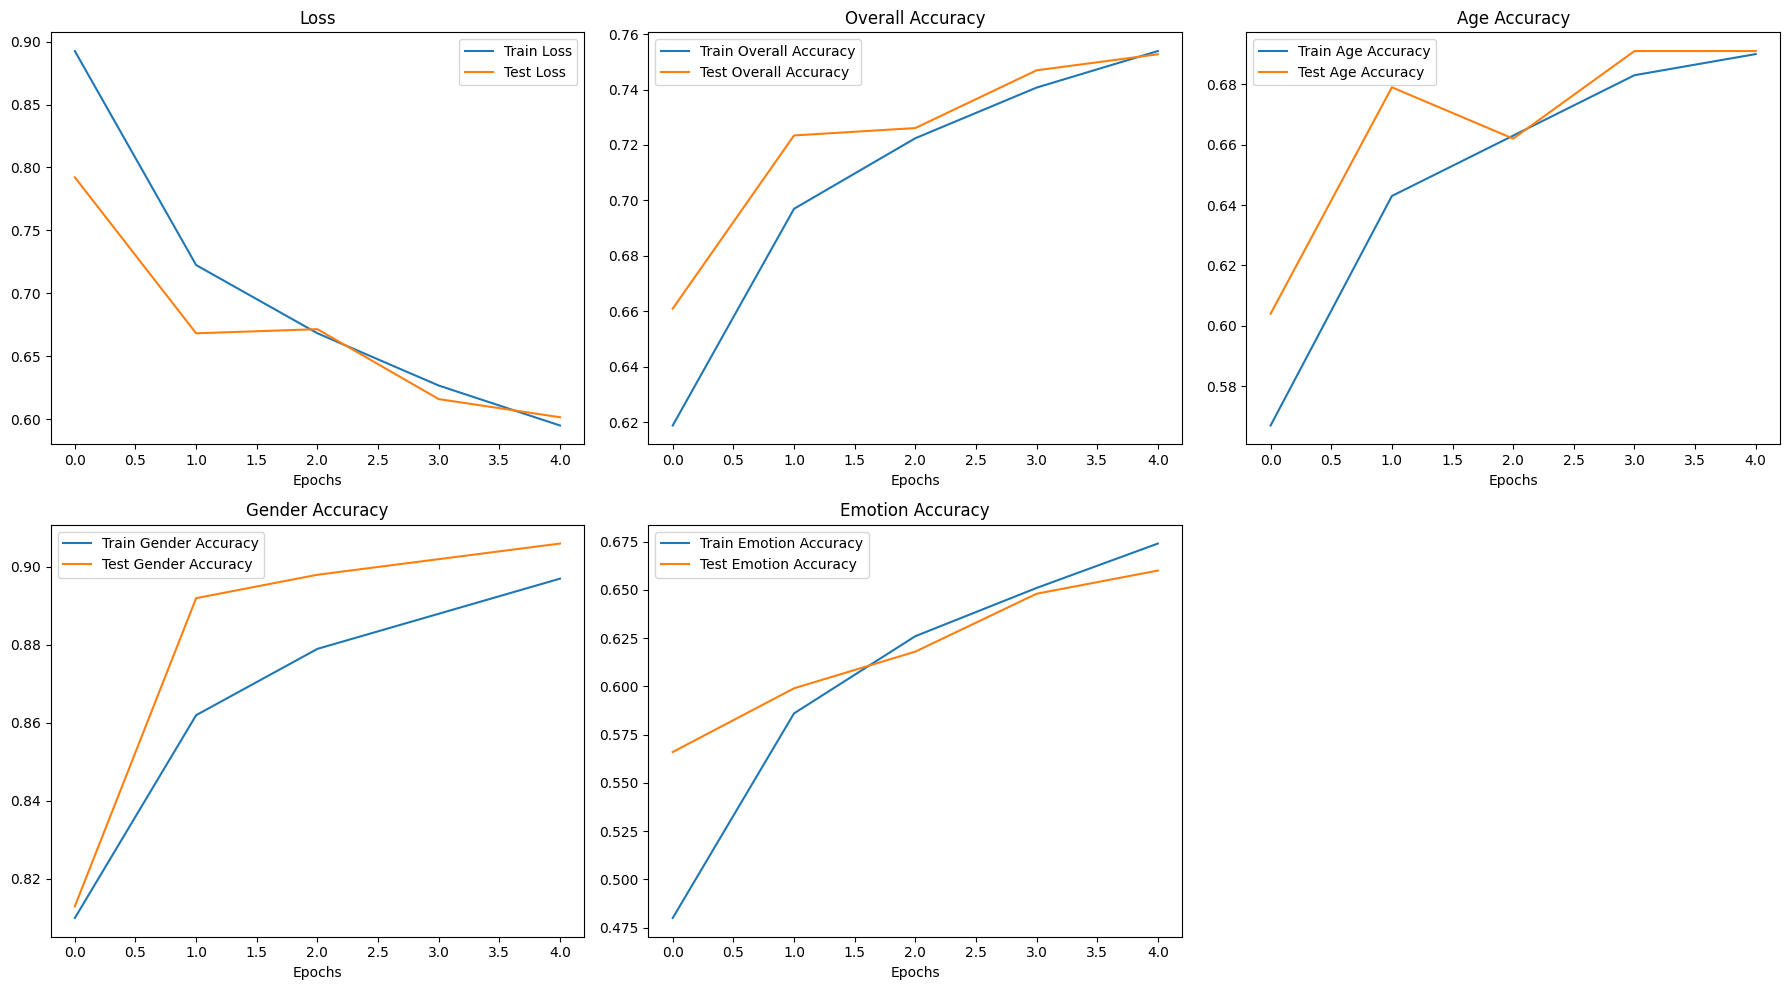

In [31]:
plot_detailed_loss_and_accuracy_curves(results=model_results)

## Model Prediction Visualization

In [32]:
test_images, test_labels = next(iter(test_combined_dataloader))
test_images.shape, test_labels.shape, test_labels

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3]),
 tensor([[ 3,  1, -1],
         [-1, -1,  0],
         [-1, -1,  3],
         [ 2,  1, -1],
         [-1, -1,  2],
         [-1, -1,  4],
         [-1, -1,  0],
         [-1, -1,  1],
         [-1, -1,  2],
         [-1, -1,  3],
         [-1, -1,  4],
         [-1, -1,  1],
         [-1, -1,  3],
         [ 2,  1, -1],
         [ 4,  0, -1],
         [-1, -1,  4]]))

Age Pred Class: tensor([3], device='cuda:0') | Gender Pred Class: tensor([1], device='cuda:0') | Emotion Pred Class: tensor([1], device='cuda:0')

Age Pred Label: Adult | Gender Pred Label: Female | Emotion Pred Label: happy

Age True Label: Young Adult | Gender True Label: Female | Emotion True Label: None


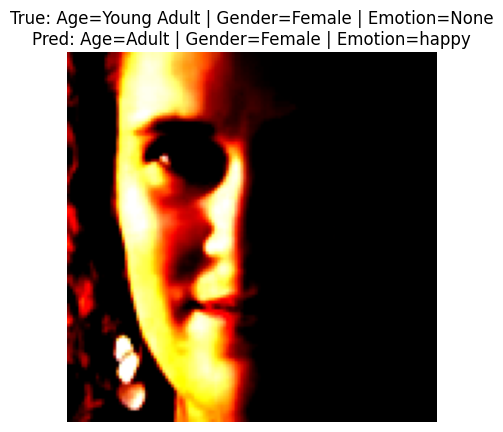

In [33]:
multi_head_model.eval()
with torch.inference_mode():
    X, y = test_images[3], test_labels[3]
    X, y = X.to(device), y.to(device)
    X = X.unsqueeze(0)
    age_pred, gender_pred, emotion_pred = multi_head_model(X)
    
    age_pred_class = age_pred.argmax(dim=1)
    gender_pred_class = gender_pred.argmax(dim=1)
    emotion_pred_class = emotion_pred.argmax(dim=1)

    age_pred_label = list(age_idx.keys())[list(age_idx.values()).index(age_pred_class)]
    gender_pred_label = 'Male' if gender_pred_class==0 else 'Female'
    emotion_pred_label = list(emotion_idx.keys())[list(emotion_idx.values()).index(emotion_pred_class)]

    age_true_label = list(age_idx.keys())[list(age_idx.values()).index(y[0])] if y[0]!= -1 else None
    gender_true_label = 'Male' if y[1] == 0 else 'Female' if y[1] == 1 else None
    emotion_true_label = list(emotion_idx.keys())[list(emotion_idx.values()).index(y[2])] if y[2] != -1 else None
    
    print(f'Age Pred Class: {age_pred_class} | Gender Pred Class: {gender_pred_class} | Emotion Pred Class: {emotion_pred_class}')
    print(f'\nAge Pred Label: {age_pred_label} | Gender Pred Label: {gender_pred_label} | Emotion Pred Label: {emotion_pred_label}')
    print(f'\nAge True Label: {age_true_label} | Gender True Label: {gender_true_label} | Emotion True Label: {emotion_true_label}')

    img = X.cpu().squeeze().permute(1, 2, 0)  # Extract and convert to HWC format
    plt.imshow(img)
    title = f'True: Age={age_true_label} | Gender={gender_true_label} | Emotion={emotion_true_label}\nPred: Age={age_pred_label} | Gender={gender_pred_label} | Emotion={emotion_pred_label}'
    plt.title(title)
    plt.axis('off')
    plt.show()

## Model Testing on Real Images

In [34]:
test_emotion.head()

path emotion
0  /kaggle/input/emotion-detection-fer/test/angry...   angry
1  /kaggle/input/emotion-detection-fer/test/angry...   angry
2  /kaggle/input/emotion-detection-fer/test/angry...   angry
3  /kaggle/input/emotion-detection-fer/test/angry...   angry
4  /kaggle/input/emotion-detection-fer/test/angry...   angry

In [35]:
test_ageutk.head()

path          age  gender
18965  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/8...        Child       1
7969   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       1
10667  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       0
6975   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       1
1399   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...        Child       0

In [36]:
age_gender = test_ageutk.groupby(['age', 'gender'], observed=True)
# age_gender = pd.DataFrame(age_gender)
age_gender.head()

path          age  gender
18965  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/8...        Child       1
7969   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       1
10667  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       0
6975   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       1
1399   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...        Child       0
13561  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/5...        Adult       0
11761  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/3...        Adult       0
8581   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...        Adult       0
3383   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/9...      Elderly       1
13900  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/3...        Adult       1
15629  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/5...        Adult       0
8824   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/5...      Elderly       0
21886  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       1
4943   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/4...        Adult       0
17195  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       0
4899   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       1
19451  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       0
16699  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/7...      Elderly       0
20728  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       1
23470  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       1
5836   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/5...        Adult       1
22543  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...        Child       1
18176  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       1
14329  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/8...        Child       1
1585   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/5...      Elderly       1
10203  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...        Child       1
18370  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       1
302    /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       0
5320   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...        Child       0
4216   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/6...      Elderly       1
16078  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/7...      Elderly       1
6396   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/5...      Elderly       1
22397  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/3...        Adult       1
917    /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       0
17158  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/5...      Elderly       0
7316   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/5...        Adult       1
13291  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/4...        Adult       1
17299  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/9...      Elderly       0
10779  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       0
13822  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...        Child       0
22095  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...        Child       1
13404  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  Young Adult       0
4145   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/5...      Elderly       0
21213  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/3...        Child       0
12097  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...        Child       0
16542  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       1
18886  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       1
13002  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       0
1654   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       0
5487   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...         Teen       0

In [37]:
emotion = test_emotion.groupby('emotion')
emotion.head()

path    emotion
0     /kaggle/input/emotion-detection-fer/test/angry...      angry
1     /kaggle/input/emotion-detection-fer/test/angry...      angry
2     /kaggle/input/emotion-detection-fer/test/angry...      angry
3     /kaggle/input/emotion-detection-fer/test/angry...      angry
4     /kaggle/input/emotion-detection-fer/test/angry...      angry
958   /kaggle/input/emotion-detection-fer/test/neutr...    neutral
959   /kaggle/input/emotion-detection-fer/test/neutr...    neutral
960   /kaggle/input/emotion-detection-fer/test/neutr...    neutral
961   /kaggle/input/emotion-detection-fer/test/neutr...    neutral
962   /kaggle/input/emotion-detection-fer/test/neutr...    neutral
2191  /kaggle/input/emotion-detection-fer/test/sad/i...        sad
2192  /kaggle/input/emotion-detection-fer/test/sad/i...        sad
2193  /kaggle/input/emotion-detection-fer/test/sad/i...        sad
2194  /kaggle/input/emotion-detection-fer/test/sad/i...        sad
2195  /kaggle/input/emotion-detection-fer/test/sad/i...        sad
3438  /kaggle/input/emotion-detection-fer/test/surpr...  surprised
3439  /kaggle/input/emotion-detection-fer/test/surpr...  surprised
3440  /kaggle/input/emotion-detection-fer/test/surpr...  surprised
3441  /kaggle/input/emotion-detection-fer/test/surpr...  surprised
3442  /kaggle/input/emotion-detection-fer/test/surpr...  surprised
4269  /kaggle/input/emotion-detection-fer/test/happy...      happy
4270  /kaggle/input/emotion-detection-fer/test/happy...      happy
4271  /kaggle/input/emotion-detection-fer/test/happy...      happy
4272  /kaggle/input/emotion-detection-fer/test/happy...      happy
4273  /kaggle/input/emotion-detection-fer/test/happy...      happy

In [38]:
test_combined = pd.concat([age_gender.head(), emotion.head()], axis=0)
test_combined.reset_index(inplace=True)

In [39]:
custom_image_path = test_combined['path'][0]
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image

tensor([[[0.2039, 0.1804, 0.1490,  ..., 0.2235, 0.2392, 0.2667],
         [0.1922, 0.1725, 0.1451,  ..., 0.2902, 0.2392, 0.2000],
         [0.1882, 0.1725, 0.1412,  ..., 0.3373, 0.2706, 0.2118],
         ...,
         [0.5608, 0.5608, 0.5569,  ..., 0.4706, 0.4471, 0.4235],
         [0.5647, 0.5608, 0.5569,  ..., 0.4549, 0.4314, 0.4275],
         [0.5804, 0.5686, 0.5608,  ..., 0.4392, 0.4157, 0.4275]],

        [[0.1569, 0.1333, 0.1020,  ..., 0.1608, 0.1765, 0.2039],
         [0.1451, 0.1255, 0.0980,  ..., 0.2275, 0.1765, 0.1373],
         [0.1412, 0.1255, 0.0941,  ..., 0.2745, 0.2078, 0.1490],
         ...,
         [0.3765, 0.3765, 0.3725,  ..., 0.3725, 0.3490, 0.3255],
         [0.3804, 0.3765, 0.3725,  ..., 0.3569, 0.3333, 0.3294],
         [0.3961, 0.3843, 0.3765,  ..., 0.3412, 0.3176, 0.3294]],

        [[0.1098, 0.0863, 0.0549,  ..., 0.1020, 0.1255, 0.1529],
         [0.0980, 0.0784, 0.0510,  ..., 0.1686, 0.1176, 0.0784],
         [0.0941, 0.0784, 0.0471,  ..., 0.2118, 0.1451, 0.

(-0.5, 199.5, 199.5, -0.5)

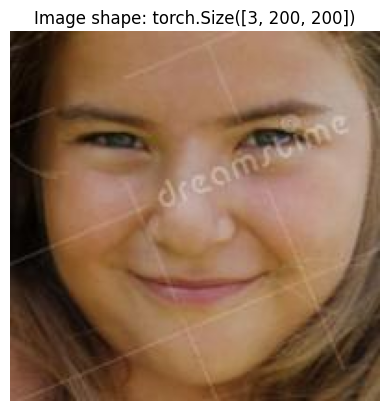

In [40]:
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [41]:
custom_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [42]:
custom_image_transform = custom_transform(custom_image)
custom_image_transform

tensor([[[-1.2859, -1.4546, -1.6007,  ..., -0.8380, -1.0187, -1.0707],
         [-1.3207, -1.4849, -1.6346,  ..., -0.6869, -0.7702, -1.0653],
         [-1.3494, -1.5557, -1.6208,  ..., -0.8726, -0.8051, -0.7754],
         ...,
         [ 0.3406,  0.2766,  0.2263,  ...,  0.0690,  0.0042, -0.1577],
         [ 0.3383,  0.3111,  0.2566,  ...,  0.0719, -0.0855, -0.2292],
         [ 0.3744,  0.3369,  0.3778,  ...,  0.0549, -0.1695, -0.2609]],

        [[-1.3952, -1.5677, -1.7171,  ..., -1.0073, -1.1921, -1.2453],
         [-1.4308, -1.5986, -1.7517,  ..., -0.8500, -0.9360, -1.2380],
         [-1.4601, -1.6710, -1.7375,  ..., -1.0264, -0.9599, -0.9305],
         ...,
         [-0.3452, -0.4106, -0.4620,  ..., -0.2377, -0.3039, -0.4695],
         [-0.3475, -0.3753, -0.4310,  ..., -0.2347, -0.3956, -0.5425],
         [-0.3106, -0.3489, -0.3071,  ..., -0.2521, -0.4814, -0.5749]],

        [[-1.3760, -1.5476, -1.6964,  ..., -1.0421, -1.2201, -1.2579],
         [-1.4114, -1.5784, -1.7308,  ..., -0

In [43]:
multi_head_model.eval()
with torch.inference_mode():
    custom_image_batch = custom_image_transform.unsqueeze(dim=0)

    print(f'Custom image with transformation: {custom_image_transform.shape}')
    print(f'Custom image with batch: {custom_image_batch.shape}')

    results = multi_head_model(custom_image_batch.to(device))

Custom image with transformation: torch.Size([3, 128, 128])
Custom image with batch: torch.Size([1, 3, 128, 128])


In [44]:
results

(tensor([[ 4.8303,  1.9997, -0.7602, -2.9625, -6.6556]], device='cuda:0'),
 tensor([[-2.3816,  1.8827]], device='cuda:0'),
 tensor([[ -3.5407,   3.2802,   0.2682,  -1.8778,  -1.5400, -33.3963, -33.3539]],
        device='cuda:0'))

In [45]:
age_probs = torch.softmax(results[0], dim=1)
gender_probs = torch.softmax(results[1], dim=1)
emotion_probs = torch.softmax(results[2], dim=1)

print(f'Age Prediction Probabilities: {age_probs}')
print(f'\nGender Prediction Probabilities: {gender_probs}')
print(f'\nEmotion Prediction Probabilities: {emotion_probs}')

Age Prediction Probabilities: tensor([[9.4062e-01, 5.5473e-02, 3.5116e-03, 3.8820e-04, 9.6634e-06]],
       device='cuda:0')

Gender Prediction Probabilities: tensor([[0.0139, 0.9861]], device='cuda:0')

Emotion Prediction Probabilities: tensor([[1.0250e-03, 9.3976e-01, 4.6228e-02, 5.4066e-03, 7.5791e-03, 1.1081e-16,
         1.1562e-16]], device='cuda:0')


In [46]:
age_labels = torch.argmax(age_probs, dim=1)
gender_labels = torch.argmax(gender_probs, dim=1)
emotion_labels = torch.argmax(emotion_probs, dim=1)

print(f'Age Prediction Labels: {age_labels}')
print(f'\nGender Prediction Labels: {gender_labels}')
print(f'\nEmotion Prediction Labels: {emotion_labels}')

Age Prediction Labels: tensor([0], device='cuda:0')

Gender Prediction Labels: tensor([1], device='cuda:0')

Emotion Prediction Labels: tensor([1], device='cuda:0')


In [47]:
age_class = age_names[age_labels]
gender_class = 'Male' if gender_labels == 0 else 'Female'
emotion_class = emotion_names[emotion_labels]

print(f'Age Prediction Class: {age_class}')
print(f'\nGender Prediction Class: {gender_class}')
print(f'\nEmotion Prediction Class: {emotion_class}')

Age Prediction Class: Child

Gender Prediction Class: Female

Emotion Prediction Class: happy


In [48]:
def pred_plot_image(model: torch.nn.Module, image_path: str, 
                    age_names: List[str], emotion_names: List[str], 
                    transform=None, device=device):
    
    target_image = torchvision.io.read_image(image_path).type(torch.float32) / 255
    
    if transform:
        target_image = transform(target_image)
        

    model.to(device)
    model.eval()

    with torch.inference_mode():
        target_image = target_image.unsqueeze(0)
        results = model(target_image.to(device))

    age_probs = torch.softmax(results[0], dim=1)
    gender_probs = torch.softmax(results[1], dim=1)
    emotion_probs = torch.softmax(results[2], dim=1)
    
    age_labels = torch.argmax(age_probs, dim=1)
    gender_labels = torch.argmax(gender_probs, dim=1)
    emotion_labels = torch.argmax(emotion_probs, dim=1)

    age_class = age_names[age_labels]
    gender_class = 'Male' if gender_labels == 0 else 'Female'
    emotion_class = emotion_names[emotion_labels]
    
    plt.imshow(target_image.squeeze().permute(1, 2, 0))

    title = f"Age Pred: {age_class} | Age Prob: {age_probs.max():.3f} \nGender Pred: {gender_class} | Gender Prob: {gender_probs.max():.3f} \nEmotion Pred: {emotion_class} | Emotion Prob: {emotion_probs.max():.3f}"
    plt.title(title)
    plt.axis(False)

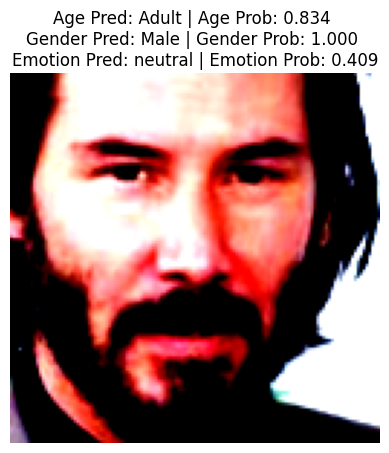

In [49]:
pred_plot_image(model=multi_head_model,age_names=age_names, emotion_names=emotion_names,
                device=device, transform=custom_transform, image_path=str(test_combined['path'][10]))

## Edge Deployment